In [1]:
#| default_exp wind_res


In [2]:
#| hide
from nbdev.showdoc import *


In [3]:
#| export
import numpy as np
import pandas as pd
from fastcore.test import *
import pkgutil
from io import BytesIO

# Wind resistance coefficients (wind_res)

> datasets of wind coefficients for a range of generic ship types



In order to caluclate the wind resistance experienced by the ship, the wind resistance loading coefficients need to be known. The wind resistance loading coefficients are dependent on the direction the wind is blowing relative to the ship. These coefficients can be found using the following three methods

- Wind tunnel test
- CFD analysis
- Coefficient datasets
- Regression formula by Fujiwara et al.

The first two and fourth approaches are used to create the coefficients specific for the ship. The third option is used when no such simulations have been performed and are based on a set of generic ship designs.

## Load wind resistance coefficients

When there has been no wind tunnel test or CDF analysis the wind resistance coefficients must be found using datasets of look up tables representing generic ship designs for a variety of classes. `pyseatrials` contains the wind loading factor datasets from ITTC. These data sets have been included as 9 dataframes depending on ship type. To load the data frame enter the name of the ship type to load. The available ship types are

- GENERAL_CARGO
- LNG_CARRIER_INT
- CRUISE_FERRY
- 280_KDWT_TANKER
- LNG_CARRIER
- HANDY_SIZE_BULK_CARRIER
- 6800_TEU_CONTAINERSHIP
- MULTI_PURPOSE_CARRIER

In [4]:
#| export
def load_wind_coefficients(vessel_type:str #The name of the vessel type. Must be one of 9 options
                     ): #returns a data set with where the first column us angle_of_attack in radians, the second is angle_of_attack in degrees, the subsequent columns names ship states
        
        "Load a wind coefficient table for a generic ship class. Datasets from ITTC"
        
        #This needs to be adapted so that the paths work on any system, using pathlib.path would be a better choice
        res = pkgutil.get_data('pyseatrials', 'wind_coef_data/'+vessel_type+'.csv')
        
        return pd.read_csv(BytesIO(res))
    

Loading a wind resistance dataset for a specific ship type is straight forward if no other dataset is available.

All datasets contain angle of attack in both radians and degrees, the subsequent columns refer to the ship state

In [5]:
general_cargo = load_wind_coefficients("GENERAL_CARGO")

general_cargo

,angle_of_attack,angle_of_attack_degs,average
0,0.000000,0,-0.60
1,0.174533,10,-0.87
2,0.349066,20,-1.00
3,0.523599,30,-1.00
4,0.698132,40,-0.88
5,0.872665,50,-0.85
6,1.047198,60,-0.65
7,1.221730,70,-0.42
8,1.396263,80,-0.27
9,1.570796,90,-0.09


## Interpolate the wind loading coefficients

The dataset loaded previously only contains the load coefficients at specific angles. Interpolation is needed to match these coefficients to the wind acting on the ship.There are many ways to interpolate these values, `pyseatrials` uses simple linear interpolation. Linear interpolation has been chosen over other approaches as it can be vectorised and reduces package dependencies. In addition the ultimate difference, between e.g. linear vs spline interpolation, in resistive force will be small compared to the magnitude of forces acting on the ship.

In [6]:
#| export
def interpolate_cx(df, #dataframe of the wind resistance dataset
                   relative_wind_direction:float, #The angle of the wind relative to the ship [rads]
                   ship_state:str #The state of the ship the resistance should be evaluated in. Chosen from the columns of the wind resistance datasets
)->float: # The dimensionless wind resistance coefficient
    
    "Find a linearly interpolated value for wind resistance coefficient"
    
    return np.interp(relative_wind_direction, df.angle_of_attack, df[ship_state])

Using the example of the general cargo ship using four different wind direction scenarios (0, 55, 180, 280 degrees) we get the interpolated loading coefficients.
Some ships have data for different states such as 'laden' and 'ballast' the General Cargo dataset only has a single state 'average'.

In [7]:
degs = [0, 55, 120, 180 ]
rads = np.deg2rad(degs) #convert the degrees to radians
cx_vals = interpolate_cx(general_cargo, rads, 'average')
print(cx_vals)

[-0.6  -0.75  0.84  0.82]


In [8]:
import pandas as pd

In [9]:
#| hide
#sanity check tests
test_df = pd.DataFrame({'angle_of_attack': [0, 2], 'cx':[0, 100]})
test_eq(interpolate_cx(test_df, 0, 'cx'), 0)
test_eq(interpolate_cx(test_df, 2, 'cx'), 100)

The wind resistance coefficients can then be used to find the actual wind resistance experienced by the ship

In [10]:
from pyseatrials.general import *

In [11]:
wind_resistance_linear = wind_resistance(air_density = 1.2,
                   wind_resistance_coef_rel = cx_vals,
                   wind_resistance_coef_zero = cx_vals[0],
                   area = 500,
                   relative_wind_speed = 20,
                   sog = 10)

#convert to kN
resistance_linear_kN = np.round(wind_resistance_linear/1000)
print(resistance_linear_kN )

[-54. -72. 119. 116.]


Other interpolations methods can be used such as spline interpolation from the `scipy` library.

In [12]:
from scipy.interpolate import make_interp_spline

In [13]:
cx_spline = make_interp_spline(general_cargo['angle_of_attack'], general_cargo['average'] )


The difference between the load coefficients produced by the two models can be shown in the plot below. Across the full range there is almost no difference.

In [14]:
import matplotlib.pyplot as plt

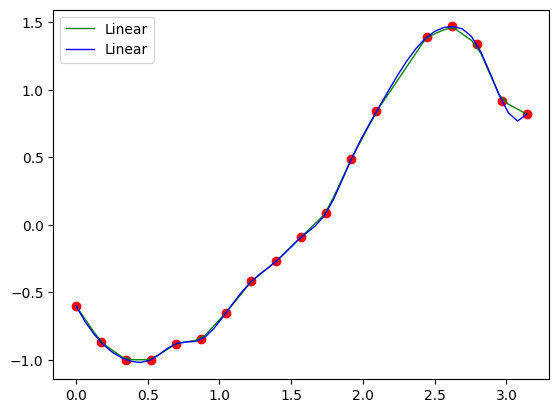

In [15]:
xs = np.linspace(-3, 3, 100)
xvals = np.linspace(0, np.pi, 50)
yinterp_lin = np.interp(xvals, general_cargo['angle_of_attack'], general_cargo['average'])
yinterp_spline = cx_spline(xvals)
plt.plot(general_cargo['angle_of_attack'], general_cargo['average'], 'ro')
plt.plot(xvals, yinterp_lin,'g-', lw=1, label='Linear')
plt.plot(xvals, yinterp_spline,'b-', lw=1, label='Linear')
plt.legend(loc='best')
plt.show()

The difference in terms of actual resistive force between linear and spline interpolation is also very small.

In [16]:
wind_resistiance_spline = wind_resistance(air_density = 1.2,
                   wind_resistance_coef_rel = cx_spline(rads),
                   wind_resistance_coef_zero = cx_spline(rads)[0],
                   area = 500,
                   relative_wind_speed = 20,
                   sog = 10)
#convert to kN
resitance_spline_kN = np.round(wind_resistiance_spline/1000)

#difference in wind resistance between the two models in kN
print('difference in kN between the two interpolation methods for all 4 angles of attack '+str(resistance_linear_kN - resitance_spline_kN))

difference in kN between the two interpolation methods for all 4 angles of attack [0. 2. 0. 0.]


## Regression formula by Fujiwara et al.

Regression formula by Fujiwara et al.

$$C_{DA} = C_{LF}cos \psi_{WR} + C_{XLI}\left(sin \psi_{WR} - \frac{1}{2}sin \psi_{WR}cos^2 \psi_{WR} \right) sin \psi_{WR}cos \psi_{WR} +C_{ALF}sin \psi_{WR}cos^3 \psi_{WR}$$

with

for $0 \leq \psi_{WR} < 90 [deg]$

$ C_{LF} = \beta_{10} + \beta_{11} \frac{A_{YV}}{L_{OA}B} + \beta_{12} \frac{C_{MC}}{L_{OA}} $

$ C_{XLI} = \delta_{10} + \delta_{11} \frac{A_{YV}}{L_{OA}h_{BR}} + \delta_{12} \frac{A_{XV}}{Bh_{BR}} $

$ C_{ALF} = \epsilon_{10} + \epsilon_{11} \frac{A_{OD}}{A_{YV}} + \epsilon_{12} \frac{B}{L_{OA}} $

for $90 < \psi_{WR} \leq 180 [deg]$

$ C_{LF} = \beta_{20} + \beta_{21} \frac{B}{L_{OA}} + \beta_{22} \frac{h_C}{L_{OA}} + \beta_{23} \frac{A_{OD}}{{L_{OA}}^2} + \beta_{24} \frac{A_{XV}}{B^2} $

$ C_{XLI} = \delta_{20} + \delta_{21} \frac{A_{YV}}{L_{OA}h_{BR}} + \delta_{22} \frac{A_{XV}}{A_{YV}} + \delta_{23} \frac{B}{L_{OA}} + \delta_{24} \frac{A_{XV}}{Bh_{BR}} $

$ C_{ALF} = \epsilon_{20} + \epsilon_{21} \frac{A_{OD}}{A_{YV}} $

for $ \psi_{WR} = 90 [deg]$

$ C_{DA| \psi_{WR}=90[deg]} = \frac{1}{2} \left(C_{DA| \psi_{WR}=90[deg] - \mu} + C_{DA| \psi_{WR}=90[deg] + \mu}   \right) $

Where

$ A_{OD} $ is the lateral projected area of superstructures on deck $ [m^2] $,

$ A_{XV} $ is the area of maximum transverse section exposed to the winds $ [m^2] $,

$ A_{YV} $ is the projected lateral area above the waterline $ [m^2] $,

$ B $ is the ship breadth $ [m] $,

$ C_{DA} $ is the wind resistance coefficient [-]

$ C_{MC} $ is the horizontal distance from midship section to centre of lateral projected area $ A_{YV} $, $ [m^2] $. This is often negative,

$ h_{BR} $ is the height of top of superstructure (bridge etc) $ [m] $,

$ h_c $ is the height from the waterline to the centre of lateral projected area $ A_{YV} $, $ [m] $,

$ L_{OA} $ is the length overall $ [m] $,

$ \mu $ is the smoothing range, normally 10 $ [deg] $,

$ \psi_{WR} $ is the relative wind direction $ [deg] $. 0 means head winds

The non-dimensional parameters $ \beta_{ij}, \delta_{ij} \ and \ \epsilon_{ij} $ used are shown in the table below



|                   | i | j      |         |         |        |       |
|-------------------|---|--------|---------|---------|--------|-------|
|                   |   | 0      | 1       | 2       | 3      | 4     |
| $ \beta_{ij} $    | 1 | 0.922  | -0.507  | -1.162  | -      | -     |
|                   | 2 | -0.018 | 5.091   | -10.367 | 3.011  | 0.341 |
| $ \delta_{ij} $   | 1 | -0.458 | -3.245  | 2.313   | -      | -     |
|                   | 2 | 1.901  | -12.727 | -24.407 | 40.310 | 5.481 |
| $ \epsilon_{ij} $ | 1 | 0.585  | 0.906   | -3.239  | -      | -     |
|                   | 2 | 0.314  | 1.117   | 0       | 0      | 0     |

**ITTC equations**: F-1 to F-7

## Fujiwara regression formula

The Fujiwara regression formula ([Fujiwara 2006](https://doi.org/10.2534/jjasnaoe.2.257))
 calcualtes the wind resistance coeficient of a vessel using the ships geometry. It is often considered the default method, due to it's adaptability to specific ships and the accessability of the input parameters. However, it's input calculation is somewhat involved, we reccomend reading either the ITTC or ISO15016 Standards for detailed description of its application. 

In [23]:

def _clf(aod:float,
        axv:float,
        ayv:float,
        cmc:float,
        hc:float,
        loa:float,
        b:float,
        wind_dir:float
        ) -> float:
    
    beta = {'10': 0.922,
                '11': -0.507,
                '12': -1.162,
                '20': -0.018,
                '21': 5.091,
                '22': -10.367,
                '23': 3.011,
                '24': 0.341
                }
    #formula is valid for angles between 0 and 180deg (assume symmetry).
    if 180<wind_dir<=360:
            wind_dir = 360-wind_dir
            
    wind_dir_rad = np.deg2rad(wind_dir)
    #apply fuji formula for lower interpolation value
    clf = (((beta['10'] + beta['11'] * ayv / (loa * b) + beta['12'] * cmc / loa) * (0 <= wind_dir_rad < np.deg2rad(90))) + #for wind between 0 and 90
           ((beta['20'] + beta['21'] * b / loa + beta['22'] * hc / loa + beta['23'] * (aod / loa **2) + beta['24'] * (axv / b **2)) * (np.deg2rad(90) < wind_dir_rad <= np.deg2rad(180)))) #for wind between 0 and 90

    return clf

def _cxli(axv:float,
         ayv:float,
         loa:float,
         hbr:float,
         b:float,
         wind_dir:float
         ) -> float:
    
    gamma = {'10': -0.458,
            '11': -3.245,
            '12': 2.313,
            '20': 1.901,
            '21': -12.727,
            '22': -24.407,
            '23': 40.310,
            '24': 5.481
            }
    #formula is valid for angles between 0 and 180deg (assume symmetry).
    if 180<wind_dir<=360:
            wind_dir = 360-wind_dir
            
    wind_dir_rad = np.deg2rad(wind_dir)
    cxli = (((gamma['10'] + gamma['11'] * ayv / (loa * hbr) + gamma['12'] * axv / (b * hbr)) * (0 <= wind_dir_rad < np.deg2rad(90))) + #for wind between 0 and 90
            ((gamma['20'] + gamma['21'] * ayv / (loa * hbr) + gamma['22'] * axv / ayv + gamma['23'] * b / loa + gamma['24'] * axv / (b * hbr)) * (np.deg2rad(90) < wind_dir_rad <= np.deg2rad(180)))) #for wind between 0 and 90
    
    return cxli

def _calf(aod:float,
         ayv:float,
         loa:float,
         b:float,
         wind_dir:float
         ) -> float:
    
    epsilon = {'10': 0.585,
               '11': 0.906,
               '12': -3.239,
               '20': 0.314,
               '21': 1.117
               }
    #formula is valid for angles between 0 and 180deg (assume symmetry).
    if 180<wind_dir<=360:
            wind_dir = 360-wind_dir
            
    wind_dir_rad = np.deg2rad(wind_dir)
    calf = (((epsilon['10'] + epsilon['11'] * aod / ayv + epsilon['12'] * b / loa) * (0 <= wind_dir_rad < np.deg2rad(90))) + #for wind between 0 and 90
            ((epsilon['20'] + epsilon['21'] * aod / ayv) * (np.deg2rad(90) < wind_dir_rad <= np.deg2rad(180)))) #for wind between 0 and 90
    
    return calf

def _caa(clf:float,
        cxli:float,
        calf:float,
        wind_dir:float
        ) -> float:
    #formula is valid for angles between 0 and 180deg (assume symmetry).
    if 180<wind_dir<=360:
            wind_dir = 360-wind_dir
            
    wind_dir_rad = np.deg2rad(wind_dir)
    
    caa = (clf * np.cos(wind_dir_rad) + 
            cxli * (np.sin(wind_dir_rad) - 0.5 * np.sin(wind_dir_rad) * np.cos(wind_dir_rad) * np.cos(wind_dir_rad)) * np.sin(wind_dir_rad) * np.cos(wind_dir_rad) +
            calf * np.sin(wind_dir_rad) * np.cos(wind_dir_rad) * np.cos(wind_dir_rad) * np.cos(wind_dir_rad)) * -1
    return caa

def _fujiwara_internal(aod:float, #is the lateral projected area of superstructures on deck in m2
                      axv:float, #is the area of maximum transverse section exposed to the winds in m2
                      ayv:float,
                      cmc:float,
                      hc:float,
                      hbr:float,
                      loa:float,
                      b:float,
                      wind_dir:float,
                      smoothing:float
                      ) -> float:
    
    """
    find if the wind angle is in the banned region (90+- smoothing and 270+- smoothing)
    if it is we need to linear interpolate over the banned range
    """
    #create two points either side of banned range (if angle is in range)
    interp_trigger = False
    if (90 - smoothing) <= wind_dir <= (90 + smoothing):
        interp_trigger = True #trigger to interpolate later on
        wind_range_min = 90 - smoothing
        wind_range_max = 90 + smoothing
        interp_range = np.array([wind_range_min, wind_range_max])
    elif (270 - smoothing) <= wind_dir <= (270 + smoothing):
        interp_trigger = True
        wind_range_min = 270 - smoothing
        wind_range_max = 270 + smoothing
        interp_range = np.array([wind_range_min, wind_range_max])
    else:
        pass
        
    #if triggered, evaluate the formula at the angle above and below banned range
    if interp_trigger:
        clf_vals = [_clf(aod = aod, axv = axv, ayv = ayv, cmc = cmc, hc = hc, loa = loa, b = b, wind_dir = i) for i in interp_range]

        cxli_vals = [_cxli(axv = axv, ayv = ayv, loa = loa, hbr = hbr, b = b, wind_dir = i) for i in interp_range]

        calf_vals = [_calf(aod = aod, ayv = ayv, loa = loa, b = b, wind_dir = i) for i in interp_range]

        caa_vals = [_caa(clf = i, cxli = j, calf = k, wind_dir = l) for i, j, k, l in zip(clf_vals, cxli_vals, calf_vals, interp_range)]
        caa_vals = np.array(caa_vals)
        
        #interpolate to the requested wind angle
        ca = np.interp(wind_dir, interp_range, caa_vals)

    #else just evaluate the formula, no dramas :)
    else:
        clf_vals = _clf(aod = aod, axv = axv, ayv = ayv, cmc = cmc, hc = hc, loa = loa, b = b, wind_dir = wind_dir)

        cxli_vals = _cxli(axv = axv, ayv = ayv, loa = loa, hbr = hbr, b = b, wind_dir = wind_dir)

        calf_vals = _calf(aod = aod, ayv = ayv, loa = loa, b = b, wind_dir = wind_dir)

        #calculate formula
        ca = _caa(clf = clf_vals, cxli = cxli_vals, calf = calf_vals, wind_dir = wind_dir)
        
    return ca

def fujiwara(aod:float, #is the lateral projected area of superstructures on deck in m2
             axv:float, #is the area of maximum transverse section exposed to the winds in m2
             ayv:float,
             cmc:float,
             hc:float,
             hbr:float,
             loa:float,
             b:float,
             wind_dir:float,
             smoothing:float
             ) -> float:
    
    #wrap 'fujiwara_internal' to accept arrays and vectorise the calculation
    
    return np.vectorize(_fujiwara_internal)(aod=aod, axv=axv, ayv=ayv, cmc=cmc, hc=hc, hbr=hbr, loa=loa, b=b, wind_dir=wind_dir, smoothing=smoothing)


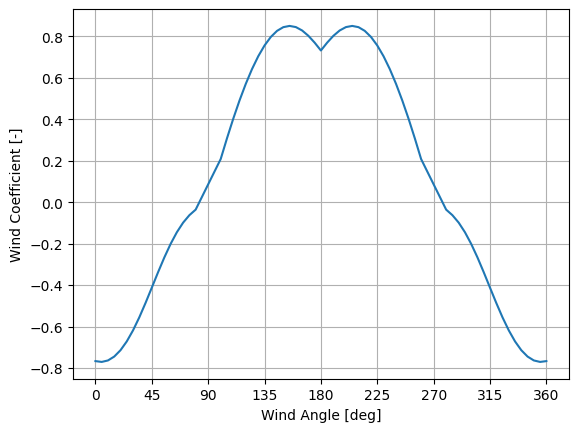

In [24]:
import matplotlib.pyplot as plt
wind_dir = np.arange(0, 361, 5)

cx = [fujiwara(aod = 905, axv = 1750, ayv = 7400, cmc = -6.6, hc = 11.72, hbr = 40.7, loa = 340, b = 62, wind_dir = i, smoothing = 10) for i in wind_dir]
plt.plot(wind_dir, cx)
plt.xlabel('Wind Angle [deg]')
plt.ylabel('Wind Coefficient [-]')
plt.xticks(np.arange(0,361,45))
plt.grid()

